<a href="https://colab.research.google.com/github/lellabhaskar/DataScience/blob/main/ML_Deploy_Salary_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib

In [2]:
import azureml.core


ModuleNotFoundError: ignored

In [3]:
pip install azureml-core

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
     |████████████████████████████████| 141 kB 48.9 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 928 kB 59.9 MB/s 
     |████████████████████████████████| 177 kB 91.0 MB/s 
     |████████████████████████████████| 206 kB 71.7 MB/s 
     |████████████████████████████████| 2.2 MB 18.2 MB/s 
     |████████████████████████████████| 146 kB 72.8 MB/s 
     |████████████████████████████████| 3.0 MB 23.0 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 40 kB 5.8 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 1.8 MB 42.6 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 
     |█████████████████████████

Azure ML SDK Modules

In [5]:
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

In [6]:
print(azureml.core.VERSION)

1.37.0


In [ ]:
# Create a workspace
ws = Workspace.create(name='salary',
                      subscription_id='',
                      resource_group='webinar',
                      create_resource_group=True,
                      location='southeastsia')

In [ ]:
ws.write_config()

In [ ]:
ws=Workspace.from_config()

In [ ]:
ws.get_details()

In [ ]:
# Create Azure ML Experiment
exp=Experiment(workspace=ws,name='salexp')

In [ ]:
run=exp.start_logging()
run.log('Experiment start time',str(datetime.datetime.now()))

In [ ]:
# Load salary dataset
sal=pd.read_csv('data/sal.csv',header=0,index_col=None)
x=sal[['x']]
y=sal[['y']]

In [ ]:
# split train and test data
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.25,random_state=42)

In [ ]:
# train the model
lm=LinearRegression()
lm.fit(x_train,y_train)

In [ ]:
# Freeze the model
filename='outputs/sal_model.pkl'
joblib.dump(lm,filename)

In [ ]:
 # Test the model
 filename='outputs/sal_model.pkl'
 loaded_model=joblib.load(fliename)
 y=loaded_model.predict([[2]])[0]
 print(y)

In [ ]:
# log metrics to azure ML Experiment
run.log('Intercept:',lm.intercept_)
run.log('Slope:',lm.coef_[0])

In [ ]:
# End Azure Ml Experiment
run.log('Experiment end time ',str(datetime.datetime.now()))
run.complete()

In [ ]:
# Get portal URL
print(run.get_portal_url())

In [ ]:
# Register the model
model= Model.register(model_path='outputs/sal_modle.pkl',
                      model_name='sal_model',
                      tags={'key':"1"},
                      description="Salary Prediction",
                      workspace=ws
                      )

In [ ]:
#defube azure ML deployment configuration
aciconfig=AciWebservice.deploy_configuration(cpu_cores=1,
                                             memory_gb=1,
                                             tags={"data":"Salary","method":"sklearn"},
                                             description="predict Stackpverflow Salary")

In [ ]:
# create enviroment configuration file
salenv=CondaDependencies()
salenv.add_conda_package("scikit-learn")

with open("salenv.yml","w") as f:
  f.write(salenv.serialize_to_string())
with open("salenv.yml","r") as f:
  print(f.read())

In [ ]:
#Create Azure ML Scoring file
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
  global model
  model_path=Model.get_model_path('sal_model')
  model=joblib.load(model_path)

def run(raw_data):
  data=np.array(json.loads(raw_data)['data'])
  y_hat=model.predict(data)
  return json.dumps(y_hat.tolist())

In [ ]:
# salenv.yml

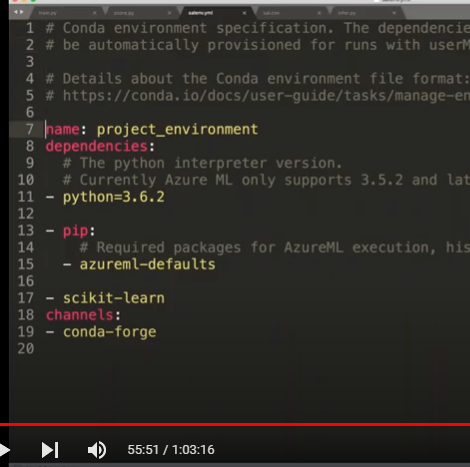

In [ ]:
# Deploy the model to azure container instance
image_config=ContainerImage.image_configuration(execution_script="score.py",
                                                runtime="python",
                                                conda_file="salenv.yml"
                                                )

In [ ]:
# Expose web service
service = Webservice.deploy_from_model(workspace=ws,
                                       name='salary-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config
                                       )
service.wait_for_deployment(show_output=True)

In [ ]:
service.wait_for_deployment(show_output=True)

In [ ]:
 # Get the web service URL
 print(service.scoring_uri)

In [ ]:
!curl -X POST \
  -H 'Content-Type':'application/json' \
  -d '{"data":[[45]]}' \
    http://9fdcdd1-2eda-4a46-812e-d2f330fa46c3.southeastasia.azurecontainer.io/score

In [ ]:
ws.delete()